In [1]:
import os
import keras
import random
import numpy as np
import sys
import operator
import math
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.applications import InceptionResNetV2
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img

import matplotlib.pyplot as plt
import itertools
from skimage import transform
from skimage.io import imread, imsave, imshow
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time

current_milli_time = lambda: int(round(time.time() * 1000))

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## Helper Functions

In [2]:
"""
    Preprocess image, normalizing and resizing it

    :param frame: RGBA frame
"""    
def preprocess_image(frame):
    
    # Normalize Pixel Values
    normalized_frame = frame/255.0 - 0.5
    
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, IMAGE_PP_SIZE)
    
    # Create a 3-Channel image
#     final_image = np.dstack((preprocessed_frame, preprocessed_frame, preprocessed_frame))
    
    return preprocessed_frame

"""
    Create 2D label list from 1D list
    
    :param labels: 1D label list
"""

def make_labels(labels):
    np_labels = np.zeros((len(labels), CLASS_NUMBER))
    
    for i in range(len(labels)):
        np_labels[i, labels[i]] = 1
    
    return np_labels

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def choices(l, k=1):
    new_list = []
    for i in range(k):
        new_list.append(random.choice(l))
    return new_list

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     print(cm)
    
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def VGG16_Model():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    x = conv_base.output
    x = Flatten()(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation="softmax")(x)
    
    model = Model(input = conv_base.input, output = predictions)
    
    return model

## Define Globals

In [3]:
IMAGE_PP_SIZE = [150, 150]
EPOCHS = 100
BATCH_SIZE = 100
TRAIN_STEP = 1591
VAL_SIZE = 100
CLASS_NUMBER = 7

RELOAD_MODEL = False

DATA_FOLDER_ROOT = "/media/matheusmortatti/External/dom-roque"
DATA_FOLDER = "/media/matheusmortatti/External/dom-roque/original"
DATA_FOLDER_PROCESSED = "/media/matheusmortatti/External/dom-roque/preprocessed"


# Train, Val, Test
DATA_RATIO = [0.6, 0.2, 0.2]

## DATA PREPROCESSING

This cell will take all the images and preprocess it, saving the results onto another folder

In [13]:
#
# If the folder doesn't exists yet, create it and preprocess all images
#

if not os.path.isdir(DATA_FOLDER_ROOT + '/preprocessed'):
    os.mkdir(DATA_FOLDER_ROOT + '/preprocessed')
    
    labels = os.listdir(DATA_FOLDER)
    for label in labels:
        folder_path = DATA_FOLDER + '/' + label
        if not os.path.isdir(folder_path):
            continue
        os.mkdir(DATA_FOLDER_PROCESSED + '/' + label)

    for label in labels:
        folder_path = DATA_FOLDER + '/' + label
        if not os.path.isdir(folder_path):
            continue

        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.split('.')[-1] != "jpg":
                    continue
                img_path = os.path.join(root, file)
                img = imread(img_path)
                x = preprocess_image(img)
#                 x = array_to_img(x)
#                 save_img(DATA_FOLDER_PROCESSED + '/' + label + '/' + file, x)
                imsave(DATA_FOLDER_PROCESSED + '/' + label + '/' + file, x)

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: /media/matheusmortatti/External/dom-roque/preprocessed/balancete/DALLEMOLE.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/matheusmortatti/.loc

## DATA AUGMENTATION

Running this cell will take your data folder and augment all the files within it.

DO NOT RUN THIS CELL TWICE

In [5]:
#
# Create more data
#

folder = DATA_FOLDER

datagen = ImageDataGenerator(rotation_range=5,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0,
                             zoom_range=0.01)

labels = os.listdir(folder)
label_count = {}

for label in labels:
    folder_path = folder + '/' + label
    if not os.path.isdir(folder_path):
        continue

    for root, dirs, files in os.walk(folder_path):
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += len(files)

label_max = max(zip(label_count.values(), label_count.keys()))[0]
print(label_max)
print()

for label in labels:
    folder_path = folder + '/' + label
    if not os.path.isdir(folder_path):
        continue
    
    
    if not os.path.isdir(folder_path + '/augmented'):
        os.mkdir(folder_path + '/augmented')
    else:
        continue
        
    amount = math.ceil(label_max / label_count[label]) - 1
    print(label_count[label])
    print(amount)
    print()

    for root, dirs, files in os.walk(folder_path):
        
        if 'augmented' in root:
            continue
            
        print(root)
        
        for file in files:
            if file.split('.')[-1] != "jpg":
                continue
            img_path = os.path.join(root, file)
            img = load_img(img_path)
            x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

            i = 0
            for batch in datagen.flow(x, 
                                      batch_size=1,
                                      save_to_dir=folder_path + '/augmented', 
                                      save_prefix='_' + str(current_milli_time()), 
                                      save_format='jpg'):
                i += 1
                if i >= amount:
                    break  # otherwise the generator would loop indefinitely

1654

7
236

/media/matheusmortatti/External/dom-roque/original/nf
/media/matheusmortatti/External/dom-roque/original/nf/NF-E
/media/matheusmortatti/External/dom-roque/original/nf/NFS


## Create Labels File

In [14]:
folder = DATA_FOLDER

random.seed(current_milli_time())

def choices(l, k):
    c = []
    for i in range(k):
        el = random.choice(l)
        c.append(el)
        l.remove(el)
    return c, l

labels = os.listdir(folder)

i = 0
train = []
test = []
val = []
for label in labels:
    if not os.path.isdir(folder + '/' + label):
        continue

    for root, dirs, files in os.walk(folder + '/' + label):
        f = []
        for file in files:
            if ('jpg' not in file) and ('jpeg' not in file):
                continue
            f.append(file)
            
        n = len(f)
        n_train = int(DATA_RATIO[0] * n)
        n_val = int(DATA_RATIO[1] * n)
        n_test = int(DATA_RATIO[2] * n)

        lt, f = choices(f, n_train)
        for l in lt:
            train.append(os.path.join(root, l) + " " + str(i) + " " + label + "\n")

        lt, f = choices(f, n_val)
        for l in lt:
            l = l.replace(' ', '\ ')
            val.append(os.path.join(root, l) + " " + str(i) + " " + label + "\n")

        lt, f = choices(f, n_test)
        for l in lt:
            l = l.replace(' ', '\ ')
            test.append(os.path.join(root, l) + " " + str(i) + " " + label + "\n")

        

    i += 1

random.shuffle(train)
random.shuffle(val)
random.shuffle(test)

with open(folder + '/' + 'labels_train.txt', 'a') as f:
    for l in train:
        f.write(l)

with open(folder + '/' + 'labels_val.txt', 'a') as f:
    for l in val:
        f.write(l)

with open(folder + '/' + 'labels_test.txt', 'a') as f:
    for l in test:
        f.write(l)

## Load Model or Create it

In [4]:
if RELOAD_MODEL:
    try:
        json_file = open('/media/matheusmortatti/External/document-classifier/models/model_imgnet_domroque.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights('/media/matheusmortatti/External/document-classifier/weights/model_imgnet_domroque.h5')
        print("here")
    except:
        model = VGG16_Model()
else:
    model = None
    model = VGG16_Model()
    
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/home/matheusmortatti/.local/lib/python3.5/site-packages/ipykernel_launcher.py:88: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [5]:

#
# Define train, validation and test lists
#

folder = DATA_FOLDER

train_labels = []
val_labels = []
test_labels = []

train_input = []
val_input = []
test_input = []

#
# Load validation dataset
#

# labels_file = open(folder + "/labels_val.txt")


# for line in labels_file:
#     sp = line.split()
    
#     img = imread(sp[0])
#     img = preprocess_image(img)
    
#     val_input.append(img)
#     val_labels.append(int(sp[1]))

# x_val = np.asarray(val_input)
# y_val = make_labels(val_labels)
    
# labels_file.close()

#
# Load training dataset
#
    
labels_file = open(folder + "/labels_train.txt")
    
for line in labels_file:
    sp = line.split()
    
    img = imread(sp[0])
    img = preprocess_image(img)
    
    train_input.append(img)
    train_labels.append(int(sp[1]))
    
    if len(train_input)%100 == 0:
        print(len(train_input))

x_train = np.asarray(train_input)
y_train = make_labels(train_labels)
    
labels_file.close()

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100
200
300


/home/matheusmortatti/.local/lib/python3.5/site-packages/PIL/Image.py:2575: DecompressionBombWarning: Image size (94080000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200


## PCA Analisys

(7325, 150, 150, 3)


Text(0,0.5,'Cumulative explained variance')

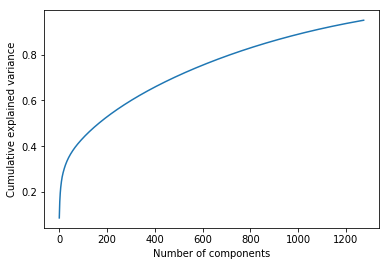

In [7]:
print(x_train.shape)
X_train = StandardScaler().fit_transform(x_train[:2000].reshape(2000, 150*150*3))
pca = PCA(0.95)
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [15]:
xp_train = pca.transform(x_train[:2000].reshape(2000, 150*150*3))

## Train!

In [11]:
def generator(x_train, y_train, batch_size = 100):
    index = 0
    while True:
        yield (x_train[index:index+batch_size,], y_train[index:index+batch_size,])
        index += batch_size
        if index > x_train.shape[0]:
            index = 0

In [12]:
MODEL_NAME = "model_vgg16_domrock"

if not os.path.isdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME):
    os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME)

unique_folder = str(current_milli_time())
os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder)

tbCallback = keras.callbacks.TensorBoard(log_dir='/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder, histogram_freq=0,  
          write_graph=True, write_images=True)

model.fit_generator(generator(x_train, y_train),
          steps_per_epoch=x_train.shape[0] // 100,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[tbCallback])

Epoch 1/100
62/62 [==============================] - 107s 2s/step - loss: 0.2418 - acc: 0.9139
Epoch 2/100
62/62 [==============================] - 108s 2s/step - loss: 0.1567 - acc: 0.9446
Epoch 3/100
62/62 [==============================] - 110s 2s/step - loss: 0.1264 - acc: 0.9575
Epoch 4/100
62/62 [==============================] - 109s 2s/step - loss: 0.1139 - acc: 0.9607
Epoch 5/100
62/62 [==============================] - 109s 2s/step - loss: 0.0894 - acc: 0.9698
Epoch 6/100
62/62 [==============================] - 111s 2s/step - loss: 0.0759 - acc: 0.9743
Epoch 7/100
62/62 [==============================] - 108s 2s/step - loss: 0.0674 - acc: 0.9773
Epoch 8/100
62/62 [==============================] - 108s 2s/step - loss: 0.0516 - acc: 0.9817
Epoch 9/100
62/62 [==============================] - 107s 2s/step - loss: 0.0377 - acc: 0.9876
Epoch 10/100
62/62 [==============================] - 108s 2s/step - loss: 0.0436 - acc: 0.9866
Epoch 11/100
62/62 [=============================

62/62 [==============================] - 105s 2s/step - loss: 0.0127 - acc: 0.9946
Epoch 87/100
62/62 [==============================] - 105s 2s/step - loss: 0.0137 - acc: 0.9948
Epoch 88/100
62/62 [==============================] - 105s 2s/step - loss: 0.0121 - acc: 0.9948
Epoch 89/100
62/62 [==============================] - 107s 2s/step - loss: 0.0661 - acc: 0.9790
Epoch 90/100
62/62 [==============================] - 108s 2s/step - loss: 0.0154 - acc: 0.9948
Epoch 91/100
62/62 [==============================] - 106s 2s/step - loss: 0.0137 - acc: 0.9945
Epoch 92/100
62/62 [==============================] - 107s 2s/step - loss: 0.0132 - acc: 0.9940
Epoch 93/100
62/62 [==============================] - 106s 2s/step - loss: 0.0126 - acc: 0.9950
Epoch 94/100
62/62 [==============================] - 106s 2s/step - loss: 0.0134 - acc: 0.9940
Epoch 95/100
62/62 [==============================] - 106s 2s/step - loss: 0.0126 - acc: 0.9946
Epoch 96/100
62/62 [==============================] -

In [13]:
#
# SAVE MODEL STRUCTURE AND WEIGHTS
#

def save_model(model):
    model_json = model.to_json()
    with open("/media/matheusmortatti/External/document-classifier/models/" + MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("/media/matheusmortatti/External/document-classifier/weights/" + MODEL_NAME + ".h5")

save_model(model)

In [9]:
#
# RELOAD VALIDATION DATA IF NECESSARY
#

val_input = []
val_labels = []

labels_file = open(DATA_FOLDER + "/labels_test.txt")

for line in labels_file:
    sp = line.split()
    
    val_input.append(preprocess_image(imread(sp[0])))
    val_labels.append(int(sp[1]))

x_val = np.asarray(val_input)
y_true = np.asarray(val_labels)
    
labels_file.close()

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


KeyboardInterrupt: 

## Predict Validation Results

In [ ]:
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

## Plot Confusion Matrix and Report

In [ ]:
labels_text = ["Balancete", "Balanco", "Contas", "DRE", "Luz A", "Luz B", "Nota Fiscal"]
y_true = np.asarray(val_labels)

plot_confusion_matrix(confusion_matrix(y_true, y_pred), labels_text)
print(classification_report(y_true, y_pred))